In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# data_dir_full = db.query('sess_name=="e15_13f1_220119"')['data_dir_full'][0]
data_dir_full = db.query('sess_name=="e13_26m1_211019"')['data_dir_full'][0]


# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [3]:
import pf_recombine_central as pfrc

In [4]:
pf_res = pfrc.main(data_dir_full)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/place_field_afterheadscan.p exists; loading---


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) 

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/place_field_afterheadscan_recombine.p


In [5]:
fr_peak = pf_res['params_recombined'].loc['fr_peak']

In [6]:
import test_change_point as tcp

In [7]:
signal = fr_peak.iloc[0].dropna().values

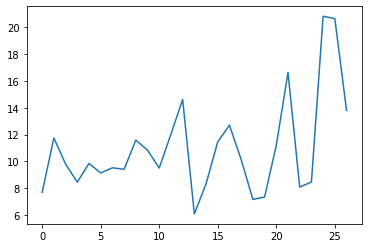

In [8]:
plt.plot(signal)

In [9]:
tcp.test_contiguity(signal,n_shuffle=200,sig_thresh=0.05,n_change_pts=1)

pval                     0.005000
exp_var_ratio            0.526892
exp_var_ratio_sh_med     0.124986
exp_var_ratio_sh_high    0.335896
exp_var_ratio_sh_low     0.040670
dtype: float64

In [11]:
reload(tcp)
X = fr_peak
res=tcp.test_contiguity_allrows(X,n_shuffle=20,sig_thresh=0.05,n_change_pts=1,min_size=2)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [13]:
res=tcp.test_contiguity_multi_n_change_pts(X,n_shuffle=20,n_change_pts_l=None,n_change_pts_max_MAX=2,min_size=2)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [26]:
reload(tcp)

<module 'test_change_point' from '/mnt/home/szheng/projects/place_variability/code/test_change_point.py'>

In [27]:
best_n = res.apply(tcp.get_n_cpd,axis=1)

In [29]:
res=tcp.detect_switch_all_steps(X,n_shuffle=10,n_change_pts_max_MAX=2,min_size=2)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [47]:
np.corrcoef(res['var_res']['tot_var'],res['var_res']['mean'])

array([[1.        , 0.60653802],
       [0.60653802, 1.        ]])

In [40]:
res['var_res'].corr()

,tot_var,mean,fit_var,resid2_mean,fit_var_ratio,resid2_mean_ratio,tot_var_norm,fit_var_norm,resid2_mean_norm
tot_var,1.000000,0.606538,0.699808,0.835797,0.179734,-0.179734,0.659862,0.454899,0.489971
mean,0.606538,1.000000,0.327917,0.581146,0.021997,-0.021997,0.033006,0.020363,0.026733
fit_var,0.699808,0.327917,1.000000,0.192702,0.562080,-0.562080,0.543173,0.782787,0.023461
resid2_mean,0.835797,0.581146,0.192702,1.000000,-0.185123,0.185123,0.488949,0.023228,0.655028
fit_var_ratio,0.179734,0.021997,0.562080,-0.185123,1.000000,-1.000000,0.254018,0.705448,-0.304743
resid2_mean_ratio,-0.179734,-0.021997,-0.562080,0.185123,-1.000000,1.000000,-0.254018,-0.705448,0.304743
tot_var_norm,0.659862,0.033006,0.543173,0.488949,0.254018,-0.254018,1.000000,0.691518,0.740551
fit_var_norm,0.454899,0.020363,0.782787,0.023228,0.705448,-0.705448,0.691518,1.000000,0.026679
resid2_mean_norm,0.489971,0.026733,0.023461,0.655028,-0.304743,0.304743,0.740551,0.026679,1.000000


In [37]:
res['corr']

tot_var    mean fit_var resid2_mean fit_var_ratio  \
0 tot_var                 -   0.000   0.000       0.000         0.000   
  mean                0.622       -   0.000       0.000         0.065   
  fit_var             0.713   0.326       -       0.000         0.000   
  resid2_mean         0.819   0.606   0.183           -         0.002   
  fit_var_ratio       0.227   0.087   0.568      -0.146             -   
  resid2_mean_ratio  -0.227  -0.087  -0.568       0.146          -1.0   
  tot_var_norm        0.679   0.055    0.52       0.526         0.208   
  fit_var_norm        0.549   0.105    0.87       0.058         0.736   
  resid2_mean_norm    0.426   -0.01  -0.009       0.605        -0.293   
1 tot_var                 -   0.000   0.000       0.000         0.019   
  mean                0.631       -   0.000       0.000         0.769   
  fit_var             0.684   0.369       -       0.000         0.000   
  resid2_mean         0.855   0.583   0.206           -         0.000   
  fit_var_ratio       0.125  -0.016   0.557      -0.229             -   
  resid2_mean_ratio  -0.125   0.016  -0.557       0.229          -1.0   
  tot_var_norm        0.666   0.078   0.584       0.478         0.257   
  fit_var_norm        0.407  -0.001   0.771      -0.002          0.69   
  resid2_mean_norm    0.555   0.116   0.049        0.71         -0.35   

                    resid2_mean_ratio tot_var_norm fit_var_norm  \
0 tot_var                       0.000        0.000        0.000   
  mean                          0.065        0.240        0.026   
  fit_var                       0.000        0.000        0.000   
  resid2_mean                   0.002        0.000        0.217   
  fit_var_ratio                    0.        0.000        0.000   
  resid2_mean_ratio                 -        0.000        0.000   
  tot_var_norm                 -0.208            -        0.000   
  fit_var_norm                 -0.736        0.584            -   
  resid2_mean_norm              0.293        0.796       -0.026   
1 tot_var                       0.019        0.000        0.000   
  mean                          0.769        0.143        0.989   
  fit_var                       0.000        0.000        0.000   
  resid2_mean                   0.000        0.000         0.97   
  fit_var_ratio                    0.        0.000        0.000   
  resid2_mean_ratio                 -        0.000        0.000   
  tot_var_norm                 -0.257            -        0.000   
  fit_var_norm                  -0.69        0.737            -   
  resid2_mean_norm               0.35          0.7        0.033   

                    resid2_mean_norm  
0 tot_var                      0.000  
  mean                         0.833  
  fit_var                      0.854  
  resid2_mean                  0.000  
  fit_var_ratio                0.000  
  resid2_mean_ratio            0.000  
  tot_var_norm                 0.000  
  fit_var_norm                 0.581  
  resid2_mean_norm                 -  
1 tot_var                      0.000  
  mean                         0.029  
  fit_var                      0.361  
  resid2_mean                  0.000  
  fit_var_ratio                0.000  
  resid2_mean_ratio            0.000  
  tot_var_norm                 0.000  
  fit_var_norm                 0.536  
  resid2_mean_norm                 -

In [29]:
# %%time 
# reload(tcp)
# res=tcp.test_contiguity_allrows(fr_peak,n_shuffle=200,sig_thresh=0.05,n_change_pts=1)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


CPU times: user 1.43 s, sys: 602 ms, total: 2.03 s
Wall time: 45.7 s


In [14]:
%%time
X = fr_peak
res = tcp.test_contiguity_multi_n_change_pts(X,n_shuffle=10,n_change_pts_l=None,n_change_pts_max_MAX=4)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


CPU times: user 16.5 s, sys: 14 s, total: 30.5 s
Wall time: 1min 34s


In [15]:
# get the best n
def get_n_cpd(row,alpha=0.05):
    ntest = len(row.dropna())
    alpha_bc = alpha / ntest
#     row_passed = row[row <= alpha_bc]
#     row_passed= row
    anysig = (row <= alpha_bc).sum()
#     if len(row_passed)==0:
    if anysig == 0:
        n = 0
    else:
        n = row.idxmin()
    return n

best_n = res.apply(get_n_cpd,axis=1)

In [16]:
def get_change_points_all_fields_different_n(X,best_n,min_size = 1):
    '''
    X: n_fields x n_trials, can have multiple tasks/trialtypes stacked
    
    '''
    cp_d = {}
    signal_pred_d = {}
    for k,signal in X.iterrows():
        n = best_n.loc[k]
        signal = signal.dropna()
        signal_pred,change_pts = cpa.predict_from_cpts_wrapper(signal.values,n,min_size=min_size)
        cp_d[k] = change_pts
        signal_pred_d[k] = pd.Series(signal_pred,index=signal.index)
    cp_d = pd.DataFrame(cp_d.values(),index=cp_d.keys())
    signal_pred_d = pd.DataFrame(signal_pred_d).T
        
    return signal_pred_d,cp_d


# get change points and fitted piecewise constant
X_pwc, cp_d=get_change_points_all_fields_different_n(X,best_n)
X_pwc_norm = X_pwc / np.nanmax(X_pwc.values,axis=1,keepdims=True)

In [83]:
# tt=1
# Xhat_one = Xhat.loc[0,1].dropna(axis=1)
# fr_trial_one = fr_trial.loc[0,1].dropna(axis=1)
def decompose_variability_onetrialtype(Xhat_one,fr_trial_one,rescale_to_max=False):
    '''
    get: total variance, variance in fit, average squared residual, mean, normalized by mean
    '''
    res = {}
    res['tot_var'] = fr_trial_one.var(axis=1,ddof=0) # ddof=0 to make the equation holds; alternatively could have the mean of resid2 replaced by /(Ntrial-1)
    res['mean'] = fr_trial_one.mean(axis=1)
    if rescale_to_max:
        Xhat_rescaled_back = Xhat_one * fr_trial_one.max(axis=1).values[:,None] # inverse of the max normalization
    else:
        Xhat_rescaled_back = Xhat_one
    res['fit_var'] = Xhat_rescaled_back.var(axis=1,ddof=0)
    pdb.set_trace()
    resid = fr_trial_one - Xhat_rescaled_back
    res['resid2_mean'] = (resid**2).mean(axis=1)
    res['fit_var_ratio'] = res['fit_var'] / res['tot_var']
    res['resid2_mean_ratio'] =1-res['fit_var_ratio']
    for k in ['tot_var','fit_var','resid2_mean']:
        res[k+'_norm'] = res[k] / res['mean']
    var_res = pd.DataFrame(res)
    
    
    
    return var_res

# def post_decomp_corr(res,pcorr_vars=['mean','fit_var_norm','resid2_mean_norm']):
#     all_corr = res.rcorr(stars=False)
#     p_corr = res[pcorr_vars].pcorr()
#     corr_res = {'all_corr':all_corr,'p_corr':p_corr}
#     return corr_res
    
    

In [78]:
def get_changes_df(X_pwc_norm,X,switch_magnitude=0.4,low_thresh=1.,high_thresh=0.):
    # get changes_df
    changes_df_all = []
    
    for k,val in X_pwc_norm.groupby(level=(0,1)):
        val = val.dropna(axis=1,how='all')
        sw_on,sw_off,changes_df = cpa.detect_switch_pwc(val,switch_magnitude=switch_magnitude,low_thresh=low_thresh,high_thresh=high_thresh)
    #     changes_df.columns=  val.columns
    #     changes_df.index=val.index
        changes_df_all.append(changes_df)
        
    changes_df_all = pd.concat(changes_df_all,axis=0)
    changes_df_all = changes_df_all.sort_index(axis=1)
    return changes_df_all

def decompose_variability_all_trialtype(X_pwc,X,rescale_to_max=False):
    
    var_res_all = {}
    for k,val in X_pwc.groupby(level=(0,1)):
        val = val.dropna(axis=1,how='all').loc[k]
        fr_one_tt = X.loc[k].dropna(axis=1,how='all')
        var_res = decompose_variability_onetrialtype(val,fr_one_tt)
        var_res_all[k] = var_res    
    var_res_all = pd.concat(var_res_all,axis=0)
    
    all_corr = var_res_all.groupby(level=0).apply(lambda x:x.rcorr(stars=False))
    p_corr = var_res_all.groupby(level=0).apply(lambda x:x.pcorr())
    
    return var_res_all,all_corr,p_corr
    

In [79]:
changes_df_all = get_changes_df(X_pwc_norm,X)
var_res_all,all_corr,p_corr = decompose_variability_all_trialtype(X_pwc,X,rescale_to_max=False)

> /tmp/ipykernel_264460/2900392745.py(17)decompose_variability_onetrialtype()
     15     res['fit_var'] = Xhat_rescaled_back.var(axis=1,ddof=0)
     16     pdb.set_trace()
---> 17     resid = fr_trial_one - Xhat_rescaled_back
     18     res['resid2_mean'] = (resid**2).mean(axis=1)
     19     res['fit_var_ratio'] = res['fit_var'] / res['tot_var']

ipdb> n
> /tmp/ipykernel_264460/2900392745.py(18)decompose_variability_onetrialtype()
     16     pdb.set_trace()
     17     resid = fr_trial_one - Xhat_rescaled_back
---> 18     res['resid2_mean'] = (resid**2).mean(axis=1)
     19     res['fit_var_ratio'] = res['fit_var'] / res['tot_var']
     20     res['resid2_mean_ratio'] =1-res['fit_var_ratio']

ipdb> c
> /tmp/ipykernel_264460/2900392745.py(17)decompose_variability_onetrialtype()
     15     res['fit_var'] = Xhat_rescaled_back.var(axis=1,ddof=0)
     16     pdb.set_trace()
---> 17     resid = fr_trial_one - Xhat_rescaled_back
     18     res['resid2_mean'] = (resid**2).mean(axis=1)
  

ipdb> c


In [88]:
var_res_all

tot_var       mean    fit_var  resid2_mean  fit_var_ratio  \
0 0.0  11  1  12.999662  11.006213   6.849420     6.150242       0.526892   
       27  0  24.028655  20.519826   6.053510    17.975145       0.251929   
           1  16.651903  16.452796   4.046118    12.605786       0.242982   
           3  13.473483  15.141640   4.122388     9.351095       0.305963   
       35  1   4.248476   3.620049   1.855994     2.392482       0.436861   
...                 ...        ...        ...          ...            ...   
1 both 250 0   3.264482   2.716905   0.000000     3.264482       0.000000   
       252 0  61.676918   8.810969  18.228328    43.448589       0.295545   
       253 0  11.279617   3.386679   5.659269     5.620347       0.501725   
       261 0  47.120092   6.580375   0.000000    47.120092       0.000000   
       266 0   6.678333   1.911848   0.000000     6.678333       0.000000   

              resid2_mean_ratio  tot_var_norm  fit_var_norm  resid2_mean_norm  
0 0.0  11  1           0.473108      1.181120      0.622323          0.558797  
       27  0           0.748071      1.170997      0.295008          0.875989  
           1           0.757018      1.012102      0.245923          0.766179  
           3           0.694037      0.889830      0.272255          0.617575  
       35  1           0.563139      1.173596      0.512699          0.660898  
...                         ...           ...           ...               ...  
1 both 250 0           1.000000      1.201545      0.000000          1.201545  
       252 0           0.704455      7.000016      2.068822          4.931193  
       253 0           0.498275      3.330584      1.671038          1.659546  
       261 0           1.000000      7.160700      0.000000          7.160700  
       266 0           1.000000      3.493131      0.000000          3.493131  

[805 rows x 9 columns]

In [50]:
# get changes_df
changes_df_all = []
for k,val in X_pwc_norm.groupby(level=(0,1)):
    val = val.dropna(axis=1,how='all')
    sw_on,sw_off,changes_df = cpa.detect_switch_pwc(val,switch_magnitude=0.4,low_thresh=1.,high_thresh=0.)
#     changes_df.columns=  val.columns
#     changes_df.index=val.index
    changes_df_all.append(changes_df)
changes_df_all = pd.concat(changes_df_all,axis=0)
changes_df_all = changes_df_all.sort_index(axis=1)

In [ ]:
# decompose variability

    
    

In [62]:
tt=0,0
Xhat_one = X_pwc.loc[tt].dropna(axis=1,how='all')
fr_trial_one = X.loc[tt].dropna(axis=1,how='all')

In [63]:
decompose_variability_onetrialtype(Xhat_one,fr_trial_one)

tot_var       mean       fit_var  resid2_mean  fit_var_ratio  \
11  1  12.999662  11.006213  6.849420e+00     6.150242   5.268921e-01   
27  0  24.028655  20.519826  6.053510e+00    17.975145   2.519288e-01   
    1  16.651903  16.452796  4.046118e+00    12.605786   2.429823e-01   
    3  13.473483  15.141640  4.122388e+00     9.351095   3.059630e-01   
35  1   4.248476   3.620049  1.855994e+00     2.392482   4.368612e-01   
...          ...        ...           ...          ...            ...   
264 1   6.752717   6.135650  3.996746e+00     2.755971   5.918722e-01   
    2   5.474198   5.516230  2.916684e+00     2.557514   5.328057e-01   
267 0  39.276127   9.707246  2.122646e+01    18.049666   5.404418e-01   
270 1  67.603817  10.813069  3.155444e-30    67.603817   4.667552e-32   
271 0   2.110622   5.380288  3.155444e-30     2.110622   1.495030e-30   

       resid2_mean_ratio  tot_var_norm  fit_var_norm  resid2_mean_norm  
11  1           0.473108      1.181120  6.223230e-01          0.558797  
27  0           0.748071      1.170997  2.950079e-01          0.875989  
    1           0.757018      1.012102  2.459228e-01          0.766179  
    3           0.694037      0.889830  2.722550e-01          0.617575  
35  1           0.563139      1.173596  5.126987e-01          0.660898  
...                  ...           ...           ...               ...  
264 1           0.408128      1.100571  6.513972e-01          0.449173  
    2           0.467194      0.992380  5.287458e-01          0.463634  
267 0           0.459558      4.046063  2.186662e+00          1.859401  
270 1           1.000000      6.252047  2.918176e-31          6.252047  
271 0           1.000000      0.392288  5.864823e-31          0.392288  

[208 rows x 9 columns]

In [52]:
changes_df_all

0    1    2    3    4    5    6    7    8    9   ...   37   38  \
0 0.0  11  1  NaN  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  ...  0.0  0.0   
       27  0  NaN  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  ...  0.0  0.0   
           1  NaN  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  ...  0.0  0.0   
           3  NaN  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  ...  0.0  0.0   
       35  1  NaN  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  0.0  ...  0.0  0.0   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1 both 250 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  NaN  NaN   
       252 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  NaN  NaN   
       253 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  NaN  NaN   
       261 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  NaN  NaN   
       266 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  NaN  NaN   

              39   40  41   42  43   44   45  46  
0 0.0  11  1 NaN  0.0 NaN  1.0 NaN  0.0  0.0 NaN  
       27  0 NaN  0.0 NaN  0.0 NaN  0.0  0.0 NaN  
           1 NaN  0.0 NaN  0.0 NaN  0.0  0.0 NaN  
           3 NaN  0.0 NaN  0.0 NaN  0.0  0.0 NaN  
       35  1 NaN  0.0 NaN  0.0 NaN  0.0  0.0 NaN  
...           ..  ...  ..  ...  ..  ...  ...  ..  
1 both 250 0 NaN  NaN NaN  NaN NaN  NaN  NaN NaN  
       252 0 NaN  NaN NaN  NaN NaN  NaN  NaN NaN  
       253 0 NaN  NaN NaN  NaN NaN  NaN  NaN NaN  
       261 0 NaN  NaN NaN  NaN NaN  NaN  NaN NaN  
       266 0 NaN  NaN NaN  NaN NaN  NaN  NaN NaN  

[805 rows x 47 columns]

In [42]:
X_pwc_norm = X_pwc / np.nanmax(X_pwc.values,axis=1,keepdims=True)

In [35]:
X_pwc

0          1          2          3          4   \
0 0.0  11  1        NaN  10.080914        NaN  10.080914        NaN   
       27  0        NaN  22.259584        NaN  22.259584        NaN   
           1        NaN  18.878751        NaN  18.878751        NaN   
           3        NaN  17.590354        NaN  17.590354        NaN   
       35  1        NaN   4.426026        NaN   4.426026        NaN   
...                 ...        ...        ...        ...        ...   
1 both 250 0   2.716905   2.716905   2.716905   2.716905   2.716905   
       252 0  12.708439  12.708439  12.708439  12.708439  12.708439   
       253 0   2.381401   2.381401   2.381401   2.381401   2.381401   
       261 0   6.580375   6.580375   6.580375   6.580375   6.580375   
       266 0   1.911848   1.911848   1.911848   1.911848   1.911848   

                     5          6          7          8          9   ...  \
0 0.0  11  1  10.080914  10.080914        NaN  10.080914  10.080914  ...   
       27  0  22.259584  22.259584        NaN  22.259584  22.259584  ...   
           1  18.878751  18.878751        NaN  18.878751  18.878751  ...   
           3  17.590354  17.590354        NaN  17.590354  17.590354  ...   
       35  1   4.426026   4.426026        NaN   4.426026   4.426026  ...   
...                 ...        ...        ...        ...        ...  ...   
1 both 250 0   2.716905   2.716905   2.716905   2.716905   2.716905  ...   
       252 0  12.708439  12.708439  12.708439  12.708439  12.708439  ...   
       253 0   2.381401   2.381401   2.381401   2.381401   2.381401  ...   
       261 0   6.580375   6.580375   6.580375   6.580375   6.580375  ...   
       266 0   1.911848   1.911848   1.911848   1.911848   1.911848  ...   

                     37         38  39         40  41         42  43  \
0 0.0  11  1  10.080914  10.080914 NaN  10.080914 NaN  18.408602 NaN   
       27  0  17.040312  17.040312 NaN  17.040312 NaN  17.040312 NaN   
           1  14.784951  14.784951 NaN  14.784951 NaN  14.784951 NaN   
           3  13.458149  13.458149 NaN  13.458149 NaN  13.458149 NaN   
       35  1   1.317259   1.317259 NaN   1.317259 NaN   1.317259 NaN   
...                 ...        ...  ..        ...  ..        ...  ..   
1 both 250 0        NaN        NaN NaN        NaN NaN        NaN NaN   
       252 0        NaN        NaN NaN        NaN NaN        NaN NaN   
       253 0        NaN        NaN NaN        NaN NaN        NaN NaN   
       261 0        NaN        NaN NaN        NaN NaN        NaN NaN   
       266 0        NaN        NaN NaN        NaN NaN        NaN NaN   

                     44         45  46  
0 0.0  11  1  18.408602  18.408602 NaN  
       27  0  17.040312  17.040312 NaN  
           1  14.784951  14.784951 NaN  
           3  13.458149  13.458149 NaN  
       35  1   1.317259   1.317259 NaN  
...                 ...        ...  ..  
1 both 250 0        NaN        NaN NaN  
       252 0        NaN        NaN NaN  
       253 0        NaN        NaN NaN  
       261 0        NaN        NaN NaN  
       266 0        NaN        NaN NaN  

[805 rows x 47 columns]

In [26]:
behavior['trials']['choice']

array([nan,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,
        1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  1., nan,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        1.,  1.])

In [21]:
signal_pred_d.loc[tt]

0          1   2          3   4          5          6   7          8   \
11  1 NaN  10.080914 NaN  10.080914 NaN  10.080914  10.080914 NaN  10.080914   
27  0 NaN  22.259584 NaN  22.259584 NaN  22.259584  22.259584 NaN  22.259584   
    1 NaN  18.878751 NaN  18.878751 NaN  18.878751  18.878751 NaN  18.878751   
    3 NaN  17.590354 NaN  17.590354 NaN  17.590354  17.590354 NaN  17.590354   
35  1 NaN   4.426026 NaN   4.426026 NaN   4.426026   4.426026 NaN   4.426026   
...    ..        ...  ..        ...  ..        ...        ...  ..        ...   
264 1 NaN   6.969369 NaN   6.969369 NaN   6.969369   6.969369 NaN   6.969369   
    2 NaN   4.354526 NaN   4.354526 NaN   4.354526   4.354526 NaN   4.354526   
267 0 NaN   6.802808 NaN   6.802808 NaN   6.802808   6.802808 NaN   6.802808   
270 1 NaN  10.813069 NaN  10.813069 NaN  10.813069  10.813069 NaN  10.813069   
271 0 NaN   5.380288 NaN   5.380288 NaN   5.380288   5.380288 NaN   5.380288   

              9   ...         37         38  39         40  41         42  43  \
11  1  10.080914  ...  10.080914  10.080914 NaN  10.080914 NaN  18.408602 NaN   
27  0  22.259584  ...  17.040312  17.040312 NaN  17.040312 NaN  17.040312 NaN   
    1  18.878751  ...  14.784951  14.784951 NaN  14.784951 NaN  14.784951 NaN   
    3  17.590354  ...  13.458149  13.458149 NaN  13.458149 NaN  13.458149 NaN   
35  1   4.426026  ...   1.317259   1.317259 NaN   1.317259 NaN   1.317259 NaN   
...          ...  ...        ...        ...  ..        ...  ..        ...  ..   
264 1   6.969369  ...   6.969369   6.969369 NaN   1.341770 NaN   1.341770 NaN   
    2   4.354526  ...   4.263272   4.263272 NaN   4.263272 NaN   4.263272 NaN   
267 0  25.761405  ...   8.827939   8.827939 NaN   8.827939 NaN   8.827939 NaN   
270 1  10.813069  ...  10.813069  10.813069 NaN  10.813069 NaN  10.813069 NaN   
271 0   5.380288  ...   5.380288   5.380288 NaN   5.380288 NaN   5.380288 NaN   

              44         45  46  
11  1  18.408602  18.408602 NaN  
27  0  17.040312  17.040312 NaN  
    1  14.784951  14.784951 NaN  
    3  13.458149  13.458149 NaN  
35  1   1.317259   1.317259 NaN  
...          ...        ...  ..  
264 1   1.341770   1.341770 NaN  
    2   4.263272   4.263272 NaN  
267 0   8.827939   8.827939 NaN  
270 1  10.813069  10.813069 NaN  
271 0   5.380288   5.380288 NaN  

[208 rows x 47 columns]

<AxesSubplot:>

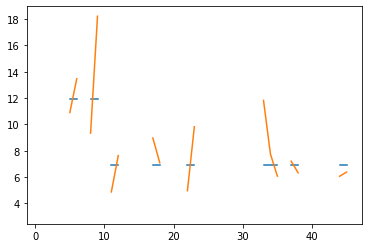

In [33]:
tt=(0,0)
uu=8
signal_pred_d.loc[tt].iloc[uu].plot()
X.loc[tt].iloc[uu].plot()

In [135]:
%%time
cp_d = {}
min_size = 1
for k,signal in X.iterrows():
    n = best_n.loc[k]
    signal = signal.dropna()
    change_pts = cpa.get_change_points_one_field(signal,n,trial_index=signal.index,model_type='dyn',min_size=min_size)
    cp_d[k] = change_pts

CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.15 s


In [136]:
cp_d = pd.DataFrame(cp_d.values(),index=cp_d.keys())

0   1   2   3
0 0.0  11  1  42.0 NaN NaN NaN
       27  0  33.0 NaN NaN NaN
           1  20.0 NaN NaN NaN
           3  20.0 NaN NaN NaN
       35  1  35.0 NaN NaN NaN
...            ...  ..  ..  ..
1 both 250 0   NaN NaN NaN NaN
       252 0  18.0 NaN NaN NaN
       253 0  28.0 NaN NaN NaN
       261 0   NaN NaN NaN NaN
       266 0   NaN NaN NaN NaN

[805 rows x 4 columns]

# putting everything together

In [96]:
import switch_detection_one_session as sdos

In [100]:
reload(sdos)
res=sdos.main(data_dir_full,test_mode=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/place_field_afterheadscan.p exists; loading---


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) 

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/place_field_afterheadscan_recombine.p
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [99]:
pf_res['params_recombined']

0          1         2          3         4   \
com 0 0.0  11  1       NaN  66.219566       NaN  66.145987       NaN   
           27  0       NaN   4.932522       NaN   4.933452       NaN   
               1       NaN  34.892476       NaN  35.202124       NaN   
               3       NaN  95.297068       NaN  96.080028       NaN   
           35  1       NaN  64.379879       NaN  64.502882       NaN   
...                    ...        ...       ...        ...       ...   
std 1 both 250 0  1.466978   1.885895  0.806211   4.133137  1.383483   
           252 0  1.181127   3.111311  4.560856   4.636047  1.240575   
           253 0       NaN   1.223574  2.515740   1.392171  2.494542   
           261 0       NaN   1.020650       NaN        NaN  2.157698   
           266 0  2.045055        NaN       NaN        NaN  0.000000   

                         5          6         7          8          9   ...  \
com 0 0.0  11  1  65.971561  64.214033       NaN  64.980755  64.662929  ...   
           27  0   5.117560   5.538741       NaN   5.976406   4.997046  ...   
               1  35.064032  35.377318       NaN  35.366250  34.591945  ...   
               3  95.509412  95.559673       NaN  95.051706  95.533977  ...   
           35  1  64.698416  63.835138       NaN  64.276967  64.714602  ...   
...                     ...        ...       ...        ...        ...  ...   
std 1 both 250 0   4.649427        NaN  1.528081   5.252907   4.913636  ...   
           252 0   2.919026   4.698907  2.942864   3.721627   3.266674  ...   
           253 0   0.672115   2.089307  2.496435   1.370531   1.208229  ...   
           261 0   3.305098   1.317893  2.189779   2.498938   2.912386  ...   
           266 0        NaN        NaN  0.475801   1.940475   1.443316  ...   

                         37         38  39         40  41         42  43  \
com 0 0.0  11  1  65.748516  63.739881 NaN  65.602258 NaN  67.009501 NaN   
           27  0   6.251680   5.856127 NaN   5.336370 NaN   5.628703 NaN   
               1  35.123117  34.728253 NaN  34.548300 NaN  35.106779 NaN   
               3  95.481599  95.081130 NaN  95.515651 NaN  95.459171 NaN   
           35  1  63.354701  64.687697 NaN  64.107422 NaN  64.756677 NaN   
...                     ...        ...  ..        ...  ..        ...  ..   
std 1 both 250 0        NaN        NaN NaN        NaN NaN        NaN NaN   
           252 0        NaN        NaN NaN        NaN NaN        NaN NaN   
           253 0        NaN        NaN NaN        NaN NaN        NaN NaN   
           261 0        NaN        NaN NaN        NaN NaN        NaN NaN   
           266 0        NaN        NaN NaN        NaN NaN        NaN NaN   

                         44         45  46  
com 0 0.0  11  1  67.297138  64.169418 NaN  
           27  0   5.198469   5.364516 NaN  
               1  35.183013  34.758014 NaN  
               3  95.700294  95.310948 NaN  
           35  1  64.404977  64.365064 NaN  
...                     ...        ...  ..  
std 1 both 250 0        NaN        NaN NaN  
           252 0        NaN        NaN NaN  
           253 0        NaN        NaN NaN  
           261 0        NaN        NaN NaN  
           266 0        NaN        NaN NaN  

[4025 rows x 47 columns]

In [95]:
res.keys()

dict_keys(['pval', 'best_n', 'X_pwc', 'X_raw', 'X_pwc_norm', 'changes_df', 'var_res', 'corr', 'p_corr'])

In [92]:
reload(tcp)
res = tcp.detect_switch_all_steps(X,n_shuffle=10,n_change_pts_max_MAX=2)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [122]:
pd.DataFrame(cp_d)

ValueError: All arrays must be of the same length

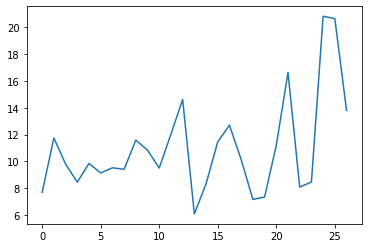

In [99]:
plt.plot(signal.values)

In [115]:
reload(cpa)
signal = X.iloc[0].dropna()
n=1
cpa.get_change_points_one_field(signal,n,trial_index=signal.index,model_type='dyn',cost='l2')

Int64Index([42], dtype='int64')

In [110]:
signal.index

Int64Index([ 1,  3,  5,  6,  8,  9, 11, 12, 15, 17, 18, 20, 22, 23, 25, 27, 29,
            31, 33, 34, 35, 37, 38, 40, 42, 44, 45],
           dtype='int64')

In [ ]:
# get change df, X_pwc, error

In [82]:
best_n

0  0.0   11   1    1
         27   0    1
              1    1
              3    1
         35   1    1
                  ..
1  both  250  0    0
         252  0    1
         253  0    1
         261  0    0
         266  0    0
Length: 805, dtype: int64

In [83]:
res

1    2    3    4
0 0.0  11  1  0.0  0.1  0.0  0.1
       27  0  0.0  1.0  0.7  0.9
           1  0.0  0.4  0.7  1.0
           3  0.0  0.2  0.4  0.8
       35  1  0.0  0.0  0.0  0.0
...           ...  ...  ...  ...
1 both 250 0  0.3  1.0  1.0  1.0
       252 0  0.0  0.0  0.0  0.0
       253 0  0.0  0.0  0.0  0.0
       261 0  0.3  0.3  0.6  1.0
       266 0  0.1  0.2  0.1  0.3

[805 rows x 4 columns]

In [33]:
res.loc[0,'both']

11   0    0.085
35   0    0.235
51   0    0.000
54   0    0.170
57   0    0.000
62   0    0.100
63   0    0.205
67   0    0.005
73   0    0.000
78   0    0.330
80   0    0.435
83   0    0.000
86   0    0.015
93   0    0.420
105  0    0.000
107  0    0.000
111  0    0.155
112  0    0.295
113  0    0.130
114  0    0.145
118  0    0.370
119  0    0.190
130  0    0.115
143  0    0.050
147  0    0.000
151  0    0.015
154  0    0.100
155  0    0.005
157  0    0.000
158  0    0.885
159  0    0.385
162  0    0.025
167  0    0.205
168  0    0.055
173  0    0.725
180  0    0.005
193  0    0.055
201  0    0.150
209  0    0.005
212  0    0.560
215  0    0.645
253  0    0.265
254  0    0.195
255  1    0.000
264  0    0.075
265  0    0.190
266  0    0.720
268  0    0.865
270  0    0.115
dtype: float64